## Logistic regression baseline model

Even though these are images, what kinds of results do we get with a logistic regression model?

Implmentation largely based on blog post: https://towardsdatascience.com/logistic-regression-with-pytorch-3c8bbea594be

In [13]:
from sklearn.model_selection import train_test_split
import torch
import torchvision
import pandas as pd
import os
import random
from torch.utils.data import DataLoader, Dataset
import json
import ast
from torchvision import transforms
from PIL import Image
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import copy
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from helper_functions import moderate_dr_plus, vtdr, dr_nodr, split_eyes_to_lists, split_eyes, initialize_model
from helper_functions import explode_dataset_per_eye, EyePacs1KDataset, get_mean_std, calc_precision_recall_stats, show_frozen_weights
from helper_functions import freeze_unfreeze_all_base_weights, train_model, unfreeze_final_layer_classifier_weights 
from helper_functions import dataset_images_root, dataset_csv_root
import wandb
from helper_functions import CustomRescaleTransform
from torch.optim.lr_scheduler import StepLR
from handpicked_dataset import handpicked_small_subset_case_ids
import torch.nn.functional as F
from torch.nn.functional import log_softmax
import matplotlib.pyplot as plt
%matplotlib inline
from torch.optim.lr_scheduler import CosineAnnealingLR
import albumentations as A
from albumentations.pytorch import ToTensorV2

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.1+cu117
Torchvision Version:  0.14.1+cu117


In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Wandb

In [15]:
# Log in to your W&B account
wandb.login()

wandb: Currently logged in as: tleyden (eyepi). Use `wandb login --relogin` to force relogin


True

## Hyperparams

In [16]:
# Set a random seed for reproducibility
random_seed = 40
random.seed(random_seed)

# Target binary classification label to train on
target_label = "dr_nodr"  # other valid target labels: moderate_dr_plus, vtdr

# The nature paper uses 587x587, but the inception network was trained on 299x299 images.  
# This needs some experimentation to find the best value.
input_size = 299

# Training set mean and stddev. 
training_image_mean = [0.2858, 0.2105, 0.1557]
training_image_std = [0.3035, 0.2469, 0.2060]

batch_size = 16

num_epochs = 200
input_dim = input_size * input_size * 3
output_dim = 1 # Two possible outputs
learning_rate = 0.0001

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu") # force CPU for now



## Define models

In [17]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, x):

        # Since we're using BCEWithLogitsLoss, we don't need to apply the sigmoid function
        # outputs = torch.sigmoid(self.linear(x))
        # return outputs
        
        return self.linear(x)

In [18]:
class FullyConnected(nn.Module):
    
    def __init__(self, input_dim, output_dim, layers=[1024,256]):
        super().__init__()
        self.fc1 = nn.Linear(in_features=input_dim,out_features=layers[0])
        self.fc2 = nn.Linear(in_features=layers[0], out_features=layers[1])
        self.fc3 = nn.Linear(in_features=layers[1], out_features=output_dim)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        # x = log_softmax(x, dim=1)  # TODO: this breaks things, remove it
        return x

## Load dataframe

In [19]:
dataset_csv = os.path.join(dataset_csv_root, "dataset_preprocessed.csv")
df = pd.read_csv(dataset_csv)
df

Unnamed: 0  case_id  age_at_encounter gender                ethnicity  \
0              0  1470916                47      F           Latin American   
1              1  1470912                40      M           Latin American   
2              2  1470880                21      F           Latin American   
3              3  1470853                44      N  ethnicity not specified   
4              4  1470702                45      N  ethnicity not specified   
...          ...      ...               ...    ...                      ...   
1093        1262   569019                38      M  ethnicity not specified   
1094        1263   560798                33      M  ethnicity not specified   
1095        1264   559463                66      F           Latin American   
1096        1265   546702                40      M           Latin American   
1097        1267   523593                29      M           Latin American   

     years_with_diabetes  hba1c  cholesterol  triglycerides  \
0         1 year or less    6.2          203          266.0   
1                4 years    6.1          223          326.0   
2                2 years    9.2          165          111.0   
3            16-20 years   11.1          242          166.0   
4         1 year or less    7.0          151          113.0   
...                  ...    ...          ...            ...   
1093          6-10 years    5.6          178           32.0   
1094      1 year or less    5.5          155          150.0   
1095             2 years    5.2          164          101.0   
1096          6-10 years    5.4          133           79.0   
1097             2 years    5.6          138          264.0   

             pupil_dilation  ...      dr_level_lft  dme_lft cataract glaucoma  \
0             not necessary  ...             No DR  No CSME      NaN      NaN   
1             not necessary  ...             No DR  No CSME      NaN      NaN   
2             not necessary  ...             No DR  No CSME      NaN      NaN   
3             not necessary  ...     Moderate NPDR  No CSME      NaN      NaN   
4             not necessary  ...             No DR  No CSME      NaN      NaN   
...                     ...  ...               ...      ...      ...      ...   
1093  1 gtt. tropicamide 1%  ...        Ungradable     CSME      NaN      NaN   
1094          not necessary  ...           Mild DR  No CSME      NaN      NaN   
1095  1 gtt. tropicamide 1%  ...  Proliferative DR  No CSME      NaN      NaN   
1096  1 gtt. tropicamide 1%  ...             No DR  No CSME      NaN      NaN   
1097          not necessary  ...             No DR  No CSME      NaN      NaN   

     occlusion maculopathy             camera  \
0          NaN         NaN  Crystalvue NFC700   
1          NaN         NaN  Crystalvue NFC700   
2          NaN         NaN          Canon CR2   
3          NaN         NaN  Crystalvue NFC700   
4          NaN         NaN  Crystalvue NFC700   
...        ...         ...                ...   
1093       NaN         NaN          Canon CR2   
1094       NaN         NaN          Canon DGi   
1095       NaN         NaN       CR1_Canon_na   
1096       NaN         NaN          Canon CR2   
1097       NaN         NaN          Canon Dgi   

                                    eye_image_filenames  \
0     ['EyePacs1KDataset/587_587_resized_images/1021...   
1     ['EyePacs1KDataset/587_587_resized_images/1021...   
2     ['EyePacs1KDataset/587_587_resized_images/8668...   
3     ['EyePacs1KDataset/587_587_resized_images/1021...   
4     ['EyePacs1KDataset/587_587_resized_images/1021...   
...                                                 ...   
1093  ['EyePacs1KDataset/587_587_resized_images/5262...   
1094  ['EyePacs1KDataset/587_587_resized_images/4004...   
1095  ['EyePacs1KDataset/587_587_resized_images/3994...   
1096  ['EyePacs1KDataset/587_587_resized_images/3873...   
1097  ['EyePacs1KDataset/587_587_resized_images/3699...   

     num_eye_image_filenames 

## Stratified train/test split

In [20]:
train_val_df, test_df = train_test_split(df, test_size=0.15, stratify=df["dr_level_rt"])
train_df, validation_df = train_test_split(train_val_df, test_size=0.20, stratify=train_val_df["dr_level_rt"])
train_df

# Temporary: overfit on a smaller subset of the data
# train_df = train_df.iloc[0:4*batch_size]
# validation_df = validation_df.iloc[0:4*batch_size]


Unnamed: 0  case_id  age_at_encounter gender                ethnicity  \
155         192  1466165                35      F           Latin American   
507         603  1425776                64      F                    Asian   
106         132  1467952                39      N  ethnicity not specified   
923        1070  1128235                40      F           Latin American   
801         941  1250520                85      M           Latin American   
..          ...      ...               ...    ...                      ...   
92          118  1468238                39      M           Latin American   
163         202  1465978                43      M  ethnicity not specified   
700         824  1343143                46      M           Latin American   
214         261  1463988                36      M  ethnicity not specified   
495         590  1427949                47      F  ethnicity not specified   

    years_with_diabetes  hba1c  cholesterol  triglycerides  \
155          6-10 years   14.0          205          247.0   
507  More than 20 years    6.7          117           57.0   
106             2 years    7.4          192          129.0   
923          6-10 years    5.6          171          268.0   
801      1 year or less    6.4           41           84.0   
..                  ...    ...          ...            ...   
92              2 years    6.3          156          322.0   
163             2 years    8.0          161           95.0   
700             3 years    6.2          207          241.0   
214      1 year or less    6.1          152          232.0   
495          6-10 years    5.2          131          180.0   

                                        pupil_dilation  ...      dr_level_lft  \
155                                      not necessary  ...  Proliferative DR   
507                              1 gtt. tropicamide 1%  ...  Proliferative DR   
106                                      not necessary  ...             No DR   
923                                      not necessary  ...     Moderate NPDR   
801                                      not necessary  ...        Ungradable   
..                                                 ...  ...               ...   
92                                       not necessary  ...             No DR   
163                                      not necessary  ...     Moderate NPDR   
700  declined (please note reason drops were declined)  ...  Proliferative DR   
214                                      not necessary  ...             No DR   
495                                      not necessary  ...       Severe NPDR   

     dme_lft cataract glaucoma occlusion maculopathy             camera  \
155  No CSME      NaN      NaN       NaN         NaN          Canon CR2   
507  No CSME      NaN      NaN       NaN         NaN    CR-2 AF_Canon_-   
106  No CSME      NaN      NaN       NaN         NaN  Crystalvue NFC700   
923  No CSME      NaN      NaN       NaN         NaN       CR1_Canon_na   
801  No CSME      NaN      NaN       NaN         NaN                NaN   
..       ...      ...      ...       ...         ...                ...   
92   No CSME      NaN      NaN       NaN         NaN   iCam_Optovue_100   
163  No CSME      NaN      NaN       NaN         NaN      NW_Topcon_400   
700     CSME      NaN      NaN       NaN        True   iCam_Optovue_100   
214  No CSME      NaN      NaN       NaN         NaN    DRS_Centervue_-   
495  No CSME      NaN      NaN       NaN         NaN    CR-2 AF_Canon_-   

                                   eye_image_filenames  \
155  ['EyePacs1KDataset/587_587_resized_images/7670...   
507  ['EyePacs1KDataset/587_587_resized_images/9906...   
106  ['EyePacs1KDataset/587_587_resized_images/1019...   
923  ['EyePacs1KDataset/587_587_resized_images/7988...   
801  ['EyePacs1KDataset/587_587_resized_images/8752...   
..                                                 ...   
92   ['EyePacs1KDataset/587_587_resized_ima

In [21]:
train_df_exploded = explode_dataset_per_eye(train_df)
validation_df_exploded = explode_dataset_per_eye(validation_df)
test_df_exploded = explode_dataset_per_eye(test_df)
train_df_exploded

case_id                                         image_path  \
0     1466165  EyePacs1KDataset/587_587_resized_images/767030...   
1     1466165  EyePacs1KDataset/587_587_resized_images/767030...   
2     1425776  EyePacs1KDataset/587_587_resized_images/990614...   
3     1425776  EyePacs1KDataset/587_587_resized_images/990614...   
4     1467952  EyePacs1KDataset/587_587_resized_images/101917...   
...       ...                                                ...   
1408  1343143  EyePacs1KDataset/587_587_resized_images/935873...   
1409  1463988  EyePacs1KDataset/587_587_resized_images/101649...   
1410  1463988  EyePacs1KDataset/587_587_resized_images/101649...   
1411  1427949  EyePacs1KDataset/587_587_resized_images/992191...   
1412  1427949  EyePacs1KDataset/587_587_resized_images/992191...   

     left_or_right_eye          dr_level      dme  moderate_dr_plus   vtdr  \
0                  lft  Proliferative DR  No CSME              True   True   
1                   rt  Proliferative DR  No CSME              True   True   
2                   rt  Proliferative DR  No CSME              True   True   
3                   rt  Proliferative DR  No CSME              True   True   
4                  lft             No DR  No CSME             False  False   
...                ...               ...      ...               ...    ...   
1408                rt             No DR  No CSME             False  False   
1409               lft             No DR  No CSME             False  False   
1410                rt             No DR  No CSME             False  False   
1411               lft       Severe NPDR  No CSME              True   True   
1412                rt       Severe NPDR  No CSME              True   True   

      dr_nodr  left_right_dr_mismatch  
0        True                   False  
1        True                   False  
2        True                   False  
3        True                   False  
4       False                   False  
...       ...                     ...  
1408    False                    True  
1409    False                   False  
1410    False                   False  
1411     True                   False  
1412     True                   False  

[1413 rows x 9 columns]

In [22]:
transform_train = A.Compose([
    
    A.Resize(input_size, input_size), 

    # Approx equivalent of transforms.ColorJitter(..)
    #         transforms.ColorJitter(
    #             brightness=0.1148, 
    #             contrast=(0.9997, 1.7705),
    #         ),
    A.RandomBrightnessContrast(
        brightness_limit=0.11,
        contrast_limit=(-0.1,0.5),
    ),

    # TODO: Use equivalent of transforms.ColorJitter(..)
    #         transforms.ColorJitter(
    #             saturation=(0.5597, 1.2749),
    #             hue=0.0251,
    #         ),
    A.HueSaturationValue(),

    # Approx equivalent of CustomRescaleTransform(crop_size=input_size, rescale_factors=[1.3, 1.5]),
    A.RandomResizedCrop(input_size, input_size, scale=(0.25, 1.0), p=0.5),

    A.HorizontalFlip(),
    A.VerticalFlip(),

    A.Normalize(
        mean=training_image_mean,
        std=training_image_std,
    ),
    ToTensorV2()
])

transform_validation_test = A.Compose([
    A.Resize(input_size, input_size), 
    A.Normalize(
        mean=training_image_mean,
        std=training_image_std,
    ),
    ToTensorV2()
])

training_dataset = EyePacs1KDataset(train_df_exploded, dataset_images_root, transform_train, target_label, rgb=True)
validation_dataset = EyePacs1KDataset(validation_df_exploded, dataset_images_root, transform_validation_test, target_label, rgb=True)

In [23]:
len(transform_train.transforms)
[x.__class__.__name__ for x in transform_train.transforms]

['Resize',
 'RandomBrightnessContrast',
 'HueSaturationValue',
 'RandomResizedCrop',
 'HorizontalFlip',
 'VerticalFlip',
 'Normalize',
 'ToTensorV2']

In [24]:
img, label = training_dataset[0]

In [25]:
img

tensor([[[-0.1406, -0.1535, -0.1406,  ...,  1.2162,  1.2032,  1.2162],
         [-0.1406, -0.1276, -0.1018,  ...,  1.2291,  1.2162,  1.2162],
         [-0.1276, -0.0889, -0.0630,  ...,  1.2420,  1.2549,  1.2291],
         ...,
         [ 1.3583,  1.3970,  1.3324,  ...,  1.7588,  1.7588,  1.7459],
         [ 1.2420,  1.2678,  1.2420,  ...,  1.7459,  1.7459,  1.7459],
         [ 1.1257,  1.1257,  1.1386,  ...,  1.7459,  1.7459,  1.7459]],

        [[ 0.0210,  0.1004,  0.1640,  ...,  1.7205,  1.6887,  1.7046],
         [ 0.0528,  0.1163,  0.1640,  ...,  1.7682,  1.7364,  1.7205],
         [ 0.1004,  0.1322,  0.1640,  ...,  1.8476,  1.8158,  1.7523],
         ...,
         [ 1.5776,  1.4505,  1.2122,  ...,  2.5464,  2.5623,  2.5782],
         [ 1.3552,  1.2758,  1.1011,  ...,  2.5464,  2.5623,  2.5623],
         [ 1.1805,  1.1011,  1.0058,  ...,  2.5464,  2.5464,  2.5623]],

        [[ 0.2150,  0.2341,  0.3102,  ...,  2.1187,  2.0616,  2.0616],
         [ 0.2150,  0.2722,  0.3483,  ...,  2

True
EyePacs1KDataset/587_587_resized_images/767030_1466165_14529836_Left External.JPG
img_tensor.shape: torch.Size([1, 587, 587])
img_tensor_reshape.shape: torch.Size([344569])


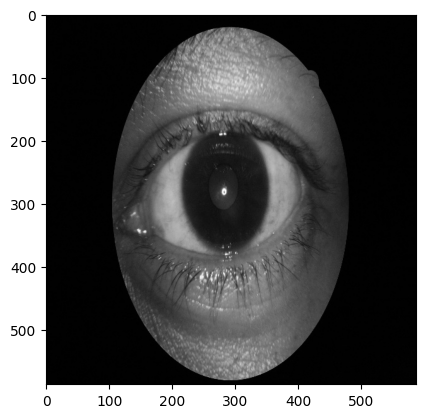

In [26]:
img_path = train_df_exploded.iloc[0]["image_path"]
print(os.path.exists(img_path))
print(img_path)
img = Image.open(img_path)
#from PIL import Image, ImageOps
#img = ImageOps.grayscale(img)


img = img.convert('L')


# rgb_im = img.convert('RGB')
# r, g, b = rgb_im.getpixel((250, 350))
# print(r, g, b)

plt.imshow(img, cmap='gray')
t = transforms.ToTensor()
img_tensor = t(img)
print(f"img_tensor.shape: {img_tensor.shape}")

img_tensor_reshape = img_tensor.flatten()
print(f"img_tensor_reshape.shape: {img_tensor_reshape.shape}")



In [27]:
# img = img.unsqueeze(0)
# img.shape
587 * 587

344569

In [28]:
# img.flatten(start_dim=1).shape 

In [29]:
training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)


## Helper function to train model

In [30]:

def train_logistic_regression_model(model, dataloaders, criterion, optimizer, lr_scheduler, num_epochs, phases, device, debug, wandb_config):
    
    since = time.time()

    validation_preds_epoch = []    
    validation_labels_epoch = []    
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch typically has a training and validation phase, eg phases = ['train', 'val']
        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

                # Save snapshots of the validation predictions and labels to generate a confusion matrix
                validation_preds_epoch = []    
                validation_labels_epoch = []    

            # Metrics
            running_loss = 0.0
            running_corrects = 0
            running_TP = 0
            running_TN = 0
            running_FP = 0
            running_FN = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)

                # Flatten the image to a single list of pixels 
                inputs = inputs.flatten(start_dim=1)

                labels = labels.to(device)
                labels_reshaped = labels.reshape(-1, 1).float()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)

                    # print(f"outputs: {outputs} labels: {labels_reshaped}")
                    loss = criterion(outputs, labels_reshaped)

                    if debug:
                        print(f"outputs: {outputs}")
                        print(f"labels_reshaped: {labels_reshaped}")
                    
                    # Since we're not running through sigmoid in the model, just treat 0.0 as the threshold 
                    # between positive and negative.  It's the same as running through sigmoid and then
                    # using 0.5 as the threshold.
                    preds = outputs > 0.0 

                    # Anything greater than 0.5 is a positive prediction.
                    # In reality this is the same as checking if the labels are equal to 1.0, because
                    # the labels are either 0.0 or 1.0
                    labels_reshaped_true_false = labels_reshaped > 0.5 

                    # _, preds = torch.max(outputs, dim=1)

                    if debug:  
                        print(f"preds: {preds}")
                        print(f"labels_reshaped_true_false: {labels_reshaped_true_false}")
                        print(f"Num correct results: {torch.sum(preds == labels_reshaped_true_false)}")
                        print(f"inputs.size(0): {inputs.size(0)}")
                        print(f"loss: {loss}")
                    
                    # Add to running stats for tracking precision and recall
                    running_TP += torch.logical_and(preds == True, labels_reshaped_true_false == True).sum().item()
                    running_FP += torch.logical_and(preds == True, labels_reshaped_true_false == False).sum().item()
                    running_TN += torch.logical_and(preds == False, labels_reshaped_true_false == False).sum().item()
                    running_FN += torch.logical_and(preds == False, labels_reshaped_true_false == True).sum().item()

                    if phase == 'val':
                        validation_preds_epoch.extend(preds.cpu().numpy())
                        validation_labels_epoch.extend(labels.cpu().numpy())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels_reshaped_true_false)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            _, epoch_precision, epoch_recall = calc_precision_recall_stats(running_TP, running_FN, running_TN, running_FP)

            print('{} Loss: {:.4f} Acc: {:.4f} Precision: {:.4f} Recall: {:.4f} LR: {}'.format(phase, epoch_loss, epoch_acc, epoch_precision, epoch_recall, lr_scheduler.get_last_lr()))
            wandb.log({
                "epoch": epoch, 
                f"{phase}_epoch_acc": epoch_acc, 
                f"{phase}_epoch_loss": epoch_loss,
                f"{phase}_epoch_precision": epoch_precision,
                f"{phase}_epoch_recall": epoch_recall,
                # f"{phase}_epoch_lr": lr_scheduler.get_last_lr()[0] # not working?
            })

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                
            if phase == 'train':
                # Learning rate scheduler step
                lr_scheduler.step()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    print('Best val Acc: {:4f}'.format(best_acc))

## Train model

In [31]:

model = LogisticRegression(input_dim, output_dim)
# model = FullyConnected(input_dim, output_dim)

# Send the model to GPU
model = model.to(device)

# torch.nn.init.xavier_uniform_(model.fc1.weight)
# torch.nn.init.xavier_uniform_(model.fc2.weight)
# torch.nn.init.xavier_uniform_(model.fc3.weight)

# torch.nn.init.xavier_uniform_(model.linear.weight)


# Use BCEWithLogitsLoss since it already contains the sigmoid function, so 
# it can take the raw logits as input
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.BCELoss()  # TODO: use BCEWithLogitsLoss, since our forward() function is not doing a sigmoid activation

# TODO: add some L2 regularization?  weight_decay=1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

dataloaders_dict = {
    "train": training_loader,
    "val": validation_loader
}
phases=['train', 'val']

lr_gamma = 1.0


# lr_scheduler = StepLR(optimizer, step_size=10, gamma=lr_gamma)

lr_scheduler = CosineAnnealingLR(optimizer,
                                T_max = 200 * 4, # Maximum number of iterations.
                                eta_min = 1e-6) # Minimum learning rate.





In [32]:
model_layer_names = []
for idx, (name, param) in enumerate(model.named_parameters()):
    model_layer_names.append(name)

wandb_config = {
    "learning_rate": learning_rate,
    "architecture": "MLPOrLogisticRegression",
    "model": model.__class__.__name__,
    "dataset": "EyePacs1K",
    "epochs": num_epochs,
    "random_seed": random_seed,
    "model_layer_names": model_layer_names,
    "lr_scheduler": lr_scheduler.__class__.__name__,
    "train_df_len": len(train_df),
    "train_transforms": [x.__class__.__name__ for x in transform_train.transforms],
    "validation_transforms": [x.__class__.__name__ for x in transform_validation_test.transforms],
}

wandb.init(
    # Use team
    entity="eyepi",
    # Set the project where this run will be logged
    project="YOUthEyePacs1K", 
    # Track hyperparameters and run metadata
    config=wandb_config
)

train_logistic_regression_model(
    model, 
    dataloaders_dict, 
    criterion, 
    optimizer, 
    lr_scheduler, 
    num_epochs, 
    phases, 
    device,
    debug=False,
    wandb_config=wandb_config,
)

Epoch 0/199
----------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [00:05<00:00, 16.46it/s]


train Loss: 2.2365 Acc: 0.5103 Precision: 0.6152 Recall: 0.5705 LR: [0.0001]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 19.84it/s]


val Loss: 2.0209 Acc: 0.6000 Precision: 0.6183 Recall: 0.8950 LR: [9.99996183243828e-05]
Epoch 1/199
----------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [00:05<00:00, 17.56it/s]


train Loss: 1.7447 Acc: 0.5464 Precision: 0.6394 Recall: 0.6227 LR: [9.99996183243828e-05]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 20.98it/s]


val Loss: 1.1754 Acc: 0.4667 Precision: 0.6015 Recall: 0.3653 LR: [9.99984733034171e-05]
Epoch 2/199
----------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [00:05<00:00, 17.25it/s]


train Loss: 1.5726 Acc: 0.5322 Precision: 0.6311 Recall: 0.5989 LR: [9.99984733034171e-05]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 21.04it/s]


val Loss: 1.5820 Acc: 0.5917 Precision: 0.6132 Recall: 0.8904 LR: [9.999656495476053e-05]
Epoch 3/199
----------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [00:05<00:00, 17.36it/s]


train Loss: 1.5578 Acc: 0.5478 Precision: 0.6390 Recall: 0.6295 LR: [9.999656495476053e-05]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 20.56it/s]


val Loss: 1.7114 Acc: 0.4389 Precision: 0.5639 Recall: 0.3425 LR: [9.999389330784221e-05]
Epoch 4/199
----------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [00:05<00:00, 17.33it/s]


train Loss: 2.0275 Acc: 0.5237 Precision: 0.6177 Recall: 0.6170 LR: [9.999389330784221e-05]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 20.80it/s]


val Loss: 1.4028 Acc: 0.5417 Precision: 0.6205 Recall: 0.6347 LR: [9.999045840386222e-05]
Epoch 5/199
----------


 18%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                      | 16/89 [00:00<00:04, 16.56it/s]


KeyboardInterrupt: 